In [1]:
#import all libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,balanced_accuracy_score,precision_recall_curve, roc_curve
from all_functions import *
from sklearn.ensemble import VotingClassifier

In [2]:
Features=18
Training='2017'
feature_selection='ANOVA'

Index_2016,Color_index_2016,All_columns,Maturity_2016,Final_Data_2016,Final_Data_Selected_2016=datacreate_2016(file='C:/Users/tusha/Downloads/Peanut_Maturity.csv'\
                                                                  ,path1='C:/All/Peanut_Maturity_Classification',W_select=199)
Index_2017,Color_index_2017,Maturity_2017,Final_Data_2017,Final_Data_Selected_2017=datacreate_2017(file='C:/Users/tusha/Downloads/Peanut_Maturity_.csv'\
                                                                  ,path2='C:/All/Peanut_Maturity_Classification_2017',W_select=199)

In [3]:
if Training=='2016':
    X_train_data,y_train_data,Train_Color_Index,Train_Index=Final_Data_Selected_2016,Maturity_2016,Color_index_2016,Index_2016
    X_test_data,y_test_data,Test_Color_Index,Test_Index=Final_Data_Selected_2017,Maturity_2017,Color_index_2017,Index_2017
elif Training=='2017':
    X_train_data,y_train_data,Train_Color_Index,Train_Index=Final_Data_Selected_2017,Maturity_2017,Color_index_2017,Index_2017
    X_test_data,y_test_data,Test_Color_Index,Test_Index=Final_Data_Selected_2016,Maturity_2016,Color_index_2016,Index_2016

In [65]:
Features=18
if feature_selection=='Strong_Feature':
    X_train,X_test,y_train,y_test=Strong_feature_train_test_dataset_create(Features=Features,X_train=X_train_data,\
                                                        y_train=y_train_data,X_test=X_test_data,\
                                                        y_test=y_test_data)
elif feature_selection=='ANOVA':
    X_train,X_test,y_train,y_test=anova_train_test_dataset_create(Features=Features,X_train=X_train_data,\
                                                        y_train=y_train_data,X_test=X_test_data,\
                                                        y_test=y_test_data)

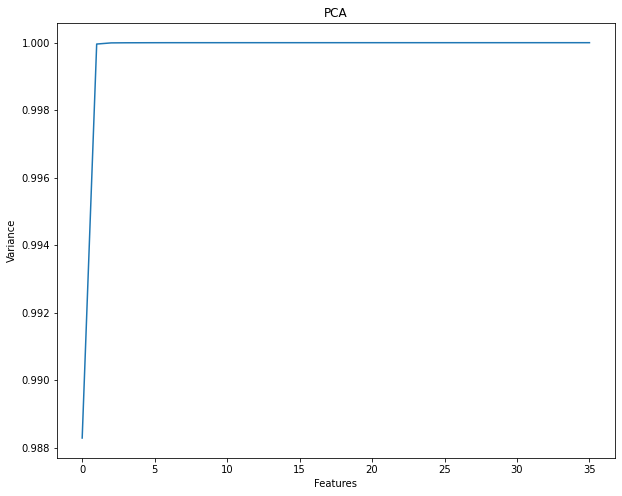

In [131]:
stdc = StandardScaler()
pca=PCA(n_components=None)
stdc.fit(X_train)
X_train_std=stdc.fit_transform(X_train)
pca.fit(X_train_std)
plt.figure(figsize=(10,8))
plt.plot(np.arange(X_train.shape[1]),np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.savefig(f'PCA_{Features}_Training_{Training}_{feature_selection}.jpg',dpi=600)

In [67]:
#Set the model LR model classification
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
#Make a pipeline containing standard scaling, PCA, estimator
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2), LogisticRegression());
#making a parameter grid by varing C, random_state and tolerance of logistic regression
parameter_grid_lr=[{'logisticregression__C':[10**i for i in [-3,-2,-1, 0, 1, 2,3,4]], 
                    'logisticregression__random_state': list(range(1,5)), 
                    'logisticregression__tol': [10**i for i in [-4,-6,-8]], 
                    'logisticregression__multi_class':['auto'], 
                    'logisticregression__max_iter': [10000], 
                    'logisticregression__class_weight': ['balanced'], 
                    'logisticregression__solver': ['lbfgs']}]
#Creating grid search object and fit in the data
#Cross_validation step can be done in grid search, that is why I avoided manual cross validation
gsr = GridSearchCV(estimator=pipe_lr,param_grid=parameter_grid_lr, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gsr = gsr.fit(X_train, y_train)

In [126]:
C=gsr.best_params_['logisticregression__C']
class_weight=gsr.best_params_['logisticregression__class_weight'];
max_iter=gsr.best_params_['logisticregression__max_iter']
multi_class=gsr.best_params_['logisticregression__multi_class']
random_state=gsr.best_params_['logisticregression__random_state']
solver=gsr.best_params_['logisticregression__solver']
tol=gsr.best_params_['logisticregression__tol']

Model_LR=LogisticRegression(C=600, penalty= 'l2', warm_start=True, class_weight= class_weight, max_iter= max_iter, multi_class='ovr',random_state=random_state, solver='liblinear', tol=tol);
pipeline_lr = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),Model_LR)
pipeline_lr=pipeline_lr.fit(X_train,y_train)

In [128]:
y_pred_train=pipeline_lr.predict(X_train)
y_pred_test=pipeline_lr.predict(X_test)

Train_Confusion_matrix_lr, Test_Confusion_matrix_lr = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_lr, Test_specificity_lr = specificity(Train_Confusion_matrix_lr), specificity(Test_Confusion_matrix_lr)
Train_accuracy_score_lr,Test_accuracy_score_lr = pipeline_lr.score(X_train, y_train),pipeline_lr.score(X_test, y_test);
Train_precision_score_lr, Test_precision_score_lr=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_lr, Test_recall_score_lr=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_lr, Test_f1_score_lr=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_lr,Test_balanced_accuracy_score_lr=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

Training_black_yellow=[pipeline_lr.score(X_train[Train_Color_Index[i]], y_train[Train_Color_Index[i]]) for i in range(4)]
Testing_black_yellow=[pipeline_lr.score(X_test[Test_Color_Index[i]], y_test[Test_Color_Index[i]]) for i in range(4)]
Training_species=[pipeline_lr.score(X_train[i*15:(i+1)*15], y_train[i*15:(i+1)*15]) for i in range(len(y_train)//45)]
Testing_species=[pipeline_lr.score(X_test[i*15:(i+1)*15], y_test[i*15:(i+1)*15]) for i in range(len(y_test)//45)]


file = open(f"Result_LR_{Features}_{Training}_{feature_selection}.txt", "w")
file.write(f"\nBest parameter for Logistic regression Model is:\n {str(pipeline_lr['logisticregression'])} for {Features} Features")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_lr},Test_result: {Test_Confusion_matrix_lr}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_lr},Test_result: {Test_accuracy_score_lr}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_lr},Test_result: {Test_precision_score_lr}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_lr},Test_result: {Test_recall_score_lr}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_lr},Test_result: {Test_f1_score_lr}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_lr},Test_result: {Test_balanced_accuracy_score_lr}")
file.write(f"\n Specificity: Train_result: {Train_specificity_lr},Test_result: {Test_specificity_lr}")
file.write(f"\n Accuracy Score_Color (Black,Brown,Yellow,Orange): Train_result: {Training_black_yellow},Test_result: {Testing_black_yellow}")
file.write(f"\n Accuracy Score_Color_species: Train_result: {Training_species},Test_result: {Testing_species}")

file.close()

In [91]:
#Set the model SVM model classification
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),svm.SVC());
param_range=[10**i for i in [-2,-1, 0, 1, 2]];
parameter_grid_svm=[{'svc__probability':[True],
                     'svc__C':param_range,
                     'svc__gamma':param_range, 
                     'svc__kernel': ['rbf', 'sigmoid'], 
                     'svc__random_state': list(range(1,50))}]
gss = GridSearchCV(estimator=pipe_svm,param_grid=parameter_grid_svm, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gss = gss.fit(X_train, y_train)

In [92]:
C=gss.best_params_['svc__C']
gamma=gss.best_params_['svc__gamma']
kernel=gss.best_params_['svc__kernel']
random_state=gss.best_params_['svc__random_state']
Model_SVM=svm.SVC(probability=True, C=C, gamma=gamma, kernel=kernel, random_state=random_state)
pipeline_svm = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),Model_SVM)
pipeline_svm=pipeline_svm.fit(X_train,y_train)

In [94]:
y_pred_train=pipeline_svm.predict(X_train)
y_pred_test=pipeline_svm.predict(X_test)
Train_Confusion_matrix_svm, Test_Confusion_matrix_svm = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_svm, Test_specificity_svm = specificity(Train_Confusion_matrix_svm), specificity(Test_Confusion_matrix_svm)
Train_accuracy_score_svm,Test_accuracy_score_svm = pipeline_svm.score(X_train, y_train),pipeline_svm.score(X_test, y_test);
Train_precision_score_svm, Test_precision_score_svm=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_svm, Test_recall_score_svm=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_svm, Test_f1_score_svm=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_svm,Test_balanced_accuracy_score_svm=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

Training_black_yellow=[pipeline_svm.score(X_train[Train_Color_Index[i]], y_train[Train_Color_Index[i]]) for i in range(4)]
Testing_black_yellow=[pipeline_svm.score(X_test[Test_Color_Index[i]], y_test[Test_Color_Index[i]]) for i in range(4)]
Training_species=[pipeline_svm.score(X_train[i*15:(i+1)*15], y_train[i*15:(i+1)*15]) for i in range(len(y_train)//45)]
Testing_species=[pipeline_svm.score(X_test[i*15:(i+1)*15], y_test[i*15:(i+1)*15]) for i in range(len(y_test)//45)]

file = open(f"Result_SVM_{Features}_{Training}_{feature_selection}.txt", "w")
file.write(f"\nBest parameter for Support Vector Machine Model is:\n {str(gsr.best_params_)}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_svm},Test_result: {Test_Confusion_matrix_svm}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_svm},Test_result: {Test_accuracy_score_svm}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_svm},Test_result: {Test_precision_score_svm}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_svm},Test_result: {Test_recall_score_svm}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_svm},Test_result: {Test_f1_score_svm}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_svm},Test_result: {Test_balanced_accuracy_score_svm}")
file.write(f"\n Specificity: Train_result: {Train_specificity_svm},Test_result: {Test_specificity_svm}")
file.write(f"\n Accuracy Score_Color (Black,Brown,Yellow,Orange): Train_result: {Training_black_yellow},Test_result: {Testing_black_yellow}")
file.write(f"\n Accuracy Score_Color_species: Train_result: {Training_species},Test_result: {Testing_species}")
file.close()

In [96]:
#Set the model Random Forest classifier
"""
Make a pipline of preprocessing, a grid of parameters for the classifier, fit the model, evaluate the model (Writing into a text file) 
"""
file = open("Result_RF.txt", "w")
pipe_rf = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),RandomForestClassifier());
max_depth = np.arange(5,20,5)
np.append(max_depth,None)
parameter_grid_rf = [{'randomforestclassifier__n_estimators': np.arange(20,100,10),
               'randomforestclassifier__max_features': ['auto', 'sqrt'],
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4],
               'randomforestclassifier__bootstrap': [True, False],
               'randomforestclassifier__random_state': [1]}]
grf = GridSearchCV(estimator=pipe_rf,param_grid=parameter_grid_rf, scoring='accuracy',cv=10,refit=True,n_jobs=-1)
grf = grf.fit(X_train, y_train)

In [102]:
n_estimators=grf.best_params_['randomforestclassifier__n_estimators']
max_depth=grf.best_params_['randomforestclassifier__max_depth']
max_features=grf.best_params_['randomforestclassifier__max_features']
min_samples_split=grf.best_params_['randomforestclassifier__min_samples_split']
min_samples_leaf=grf.best_params_['randomforestclassifier__min_samples_leaf']
bootstrap=grf.best_params_['randomforestclassifier__bootstrap']
Model_RF=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap,
                               random_state=1)
pipeline_rf = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),Model_RF)
pipeline_rf=pipeline_rf.fit(X_train,y_train)

In [104]:
y_pred_train=pipeline_rf.predict(X_train)
y_pred_test=pipeline_rf.predict(X_test)

Train_Confusion_matrix_rf, Test_Confusion_matrix_rf = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_rf, Test_specificity_rf = specificity(Train_Confusion_matrix_rf), specificity(Test_Confusion_matrix_rf)
Train_accuracy_score_rf,Test_accuracy_score_rf = pipeline_rf.score(X_train, y_train),pipeline_rf.score(X_test, y_test);
Train_precision_score_rf, Test_precision_score_rf=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_rf, Test_recall_score_rf=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_rf, Test_f1_score_rf=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_rf,Test_balanced_accuracy_score_rf=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

Training_black_yellow=[pipeline_rf.score(X_train[Train_Color_Index[i]], y_train[Train_Color_Index[i]]) for i in range(4)]
Testing_black_yellow=[pipeline_rf.score(X_test[Test_Color_Index[i]], y_test[Test_Color_Index[i]]) for i in range(4)]
Training_species=[pipeline_rf.score(X_train[i*15:(i+1)*15], y_train[i*15:(i+1)*15]) for i in range(len(y_train)//45)]
Testing_species=[pipeline_rf.score(X_test[i*15:(i+1)*15], y_test[i*15:(i+1)*15]) for i in range(len(y_test)//45)]


file = open(f"Result_RF_{Features}_{Training}_{feature_selection}.txt", "w")
file.write(f"\nBest parameter for Random Forest Model is:\n {str(pipeline_rf['randomforestclassifier'])}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_rf},Test_result: {Test_Confusion_matrix_rf}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_rf},Test_result: {Test_accuracy_score_rf}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_rf},Test_result: {Test_precision_score_rf}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_rf},Test_result: {Test_recall_score_rf}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_rf},Test_result: {Test_f1_score_rf}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_rf},Test_result: {Test_balanced_accuracy_score_rf}")
file.write(f"\n Specificity: Train_result: {Train_specificity_rf},Test_result: {Test_specificity_rf}")
file.write(f"\n Accuracy Score_Color (Black,Brown,Yellow,Orange): Train_result: {Training_black_yellow},Test_result: {Testing_black_yellow}")
file.write(f"\n Accuracy Score_Color_species: Train_result: {Training_species},Test_result: {Testing_species}")
file.close()

In [109]:
ensemble = VotingClassifier(estimators=[('lr', Model_LR), ('svm', Model_SVM), ('rf', Model_RF)], voting='soft')
pipeline_ensemble = make_pipeline(StandardScaler(),PCA(n_components=2*Features-2),ensemble)
pipeline_ensemble = pipeline_ensemble.fit(X_train, y_train)

y_pred_train=pipeline_ensemble.predict(X_train)
y_pred_test=pipeline_ensemble.predict(X_test)

Train_Confusion_matrix_en, Test_Confusion_matrix_en = confusion_matrix(y_train,y_pred_train), \
confusion_matrix(y_test,y_pred_test)
Train_specificity_en, Test_specificity_en = specificity(Train_Confusion_matrix_en), specificity(Test_Confusion_matrix_en)
Train_accuracy_score_en,Test_accuracy_score_en = pipeline_ensemble.score(X_train, y_train),pipeline_ensemble.score(X_test, y_test);
Train_precision_score_en, Test_precision_score_en=precision_score(y_train,y_pred_train), precision_score(y_test,y_pred_test)
Train_recall_score_en, Test_recall_score_en=recall_score(y_train,y_pred_train), recall_score(y_test,y_pred_test)
Train_f1_score_en, Test_f1_score_en=f1_score(y_train,y_pred_train), f1_score(y_test,y_pred_test)
Train_balanced_accuracy_score_en,Test_balanced_accuracy_score_en=balanced_accuracy_score(y_train,y_pred_train),\
balanced_accuracy_score(y_test,y_pred_test)

Training_black_yellow=[pipeline_ensemble.score(X_train[Train_Color_Index[i]], y_train[Train_Color_Index[i]]) for i in range(4)]
Testing_black_yellow=[pipeline_ensemble.score(X_test[Test_Color_Index[i]], y_test[Test_Color_Index[i]]) for i in range(4)]
Training_species=[pipeline_ensemble.score(X_train[i*15:(i+1)*15], y_train[i*15:(i+1)*15]) for i in range(len(y_train)//45)]
Testing_species=[pipeline_ensemble.score(X_test[i*15:(i+1)*15], y_test[i*15:(i+1)*15]) for i in range(len(y_test)//45)]

file = open(f"Result_ensemble_{Features}_{Training}_{feature_selection}.txt", "w")
file.write(f"\nBest parameter for Random Forest Model is:\n {str(pipeline_ensemble['votingclassifier'])}")
file.write(f"\n Metrics: Train_result ,Test_result ")
file.write(f"\n Confusion_matrix: Train_result: {Train_Confusion_matrix_en},Test_result: {Test_Confusion_matrix_en}")
file.write(f"\n Accuracy_score: Train_result: {Train_accuracy_score_en},Test_result: {Test_accuracy_score_en}")
file.write(f"\n Precision_score: Train_result: {Train_precision_score_en},Test_result: {Test_precision_score_en}")
file.write(f"\n Recall_score: Train_result: {Train_recall_score_en},Test_result: {Test_recall_score_en}")
file.write(f"\n f1_score: Train_result: {Train_f1_score_en},Test_result: {Test_f1_score_en}")
file.write(f"\n Balanced_accuracy: Train_result: {Train_balanced_accuracy_score_en},Test_result: {Test_balanced_accuracy_score_en}")
file.write(f"\n Accuracy Score_Color (Black,Brown,Yellow,Orange): Train_result: {Training_black_yellow},Test_result: {Testing_black_yellow}")
file.write(f"\n Accuracy Score_Color_species: Train_result: {Training_species},Test_result: {Testing_species}")
file.close()

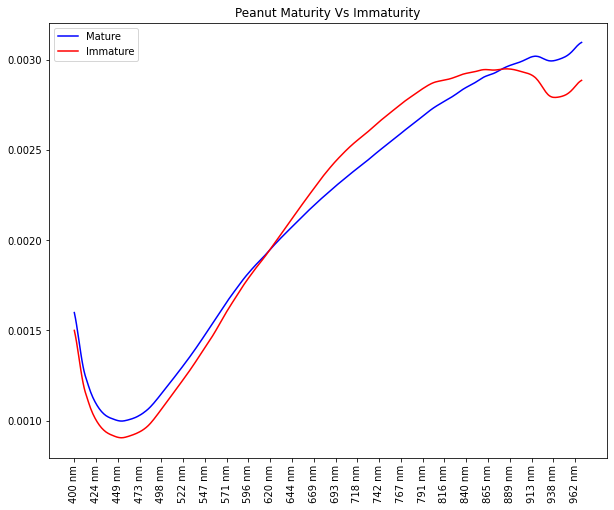

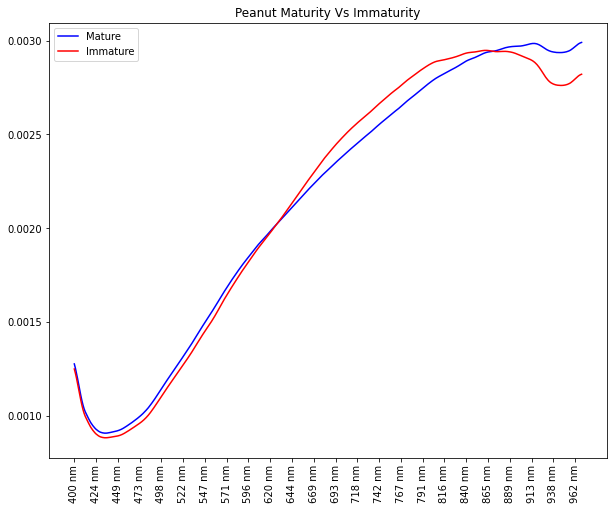

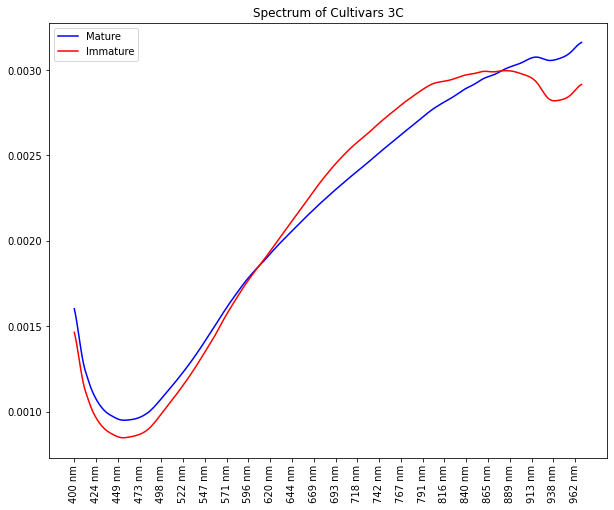

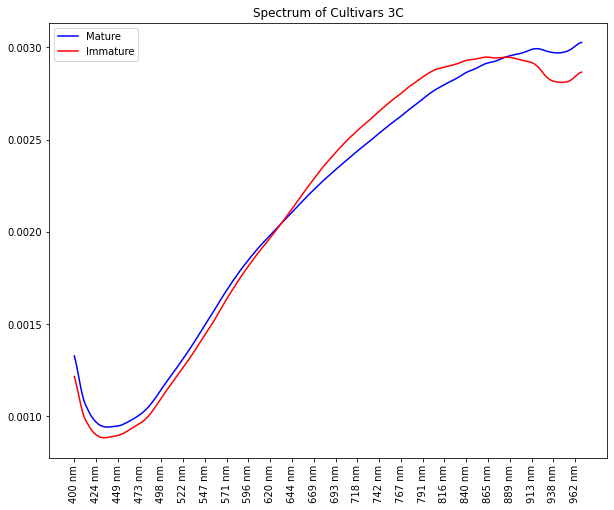

In [110]:
#Plotting ROC_AUC curve and Precision Recall_curve

plot_cultivars(Feature=Final_Data_2017,Wavelength=All_columns,Label=Maturity_2017,year='2017',Cultivar='All',Index=Index_2017)
plot_cultivars(Feature=Final_Data_2016,Wavelength=All_columns,Label=Maturity_2016,year='2016',Cultivar='All',Index=Index_2016)
plot_cultivars(Feature=Final_Data_2017,Wavelength=All_columns,Label=Maturity_2017,year='2017',Cultivar='3C',Index=Index_2017)
plot_cultivars(Feature=Final_Data_2016,Wavelength=All_columns,Label=Maturity_2016,year='2016',Cultivar='3C',Index=Index_2016)

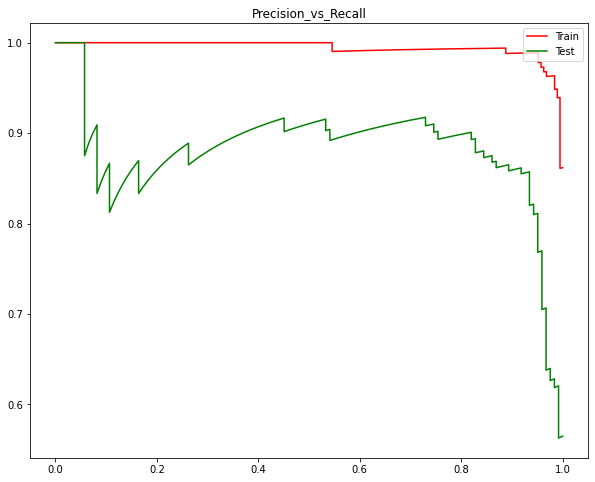

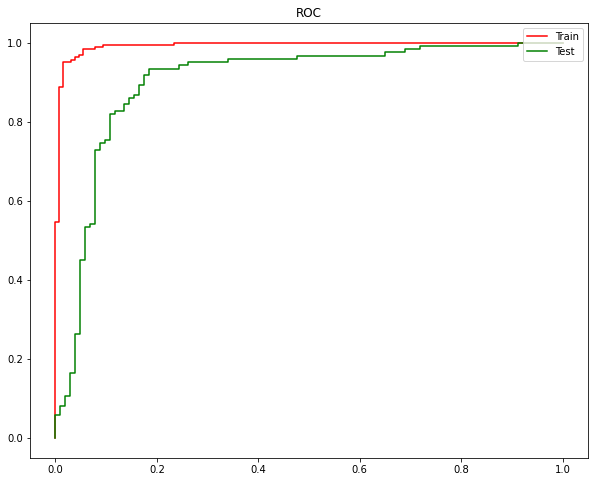

In [113]:
y_pred_train=pipeline_lr.predict_proba(X_train)
y_pred_test=pipeline_lr.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.title('Precision_vs_Recall')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'LR_Precision_vs_Recall_Features_{Features}_Training_{Training}.jpg',dpi=600)
plt.figure(figsize=(10,8))
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.title('ROC')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'LR_ROC_Features_{Features}_Training_{Training}_{feature_selection}.jpg',dpi=600)

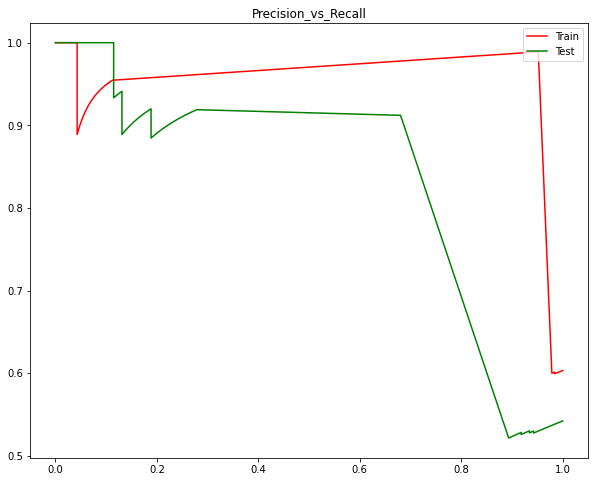

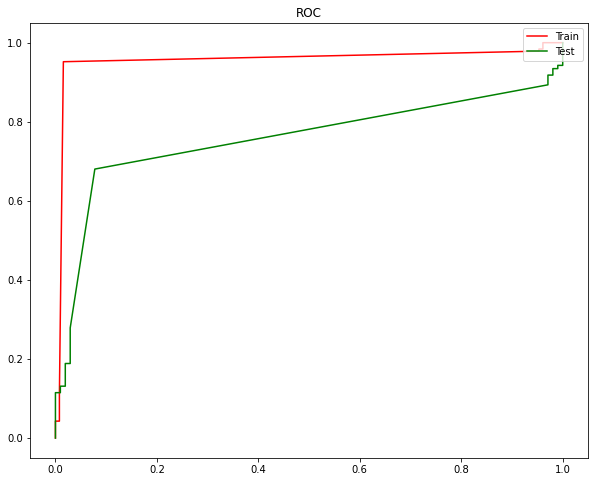

In [114]:
#Plotting ROC_AUC curve and Precision Recall_curve

y_pred_train=pipeline_svm.predict_proba(X_train)
y_pred_test=pipeline_svm.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.title('Precision_vs_Recall')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'SVM_Precision_vs_Recall_Features_{Features}_Training_{Training}.jpg',dpi=600)
plt.figure(figsize=(10,8))
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.title('ROC')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'SVM_ROC_Features_{Features}_Training_{Training}_{feature_selection}.jpg',dpi=600)

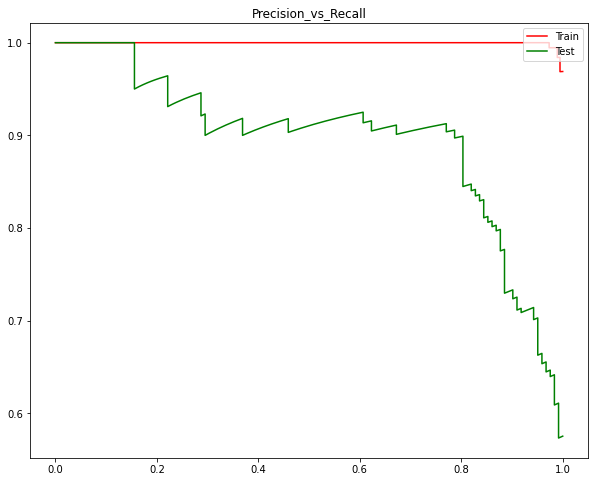

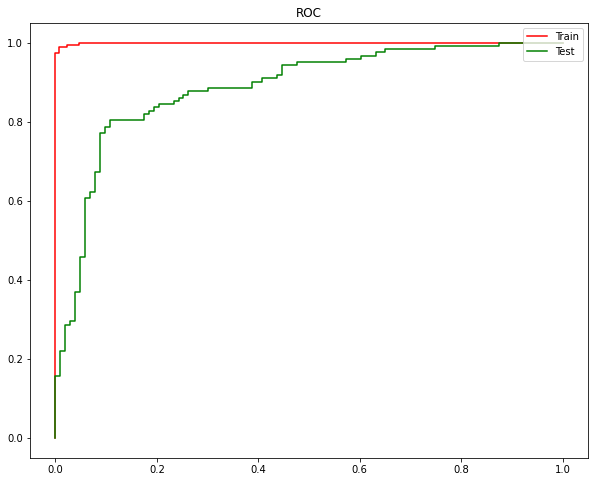

In [115]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=pipeline_rf.predict_proba(X_train)
y_pred_test=pipeline_rf.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.title('Precision_vs_Recall')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'RF_Precision_vs_Recall_Features_{Features}_Training_{Training}.jpg',dpi=600)
plt.figure(figsize=(10,8))
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.title('ROC')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'RF_ROC_Features_{Features}_Training_{Training}_{feature_selection}.jpg',dpi=600)

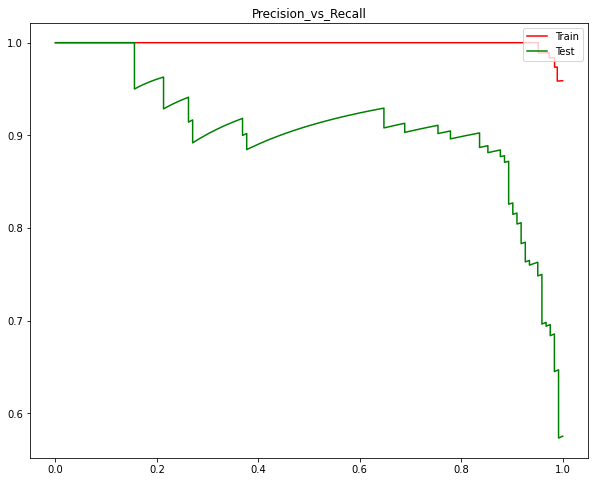

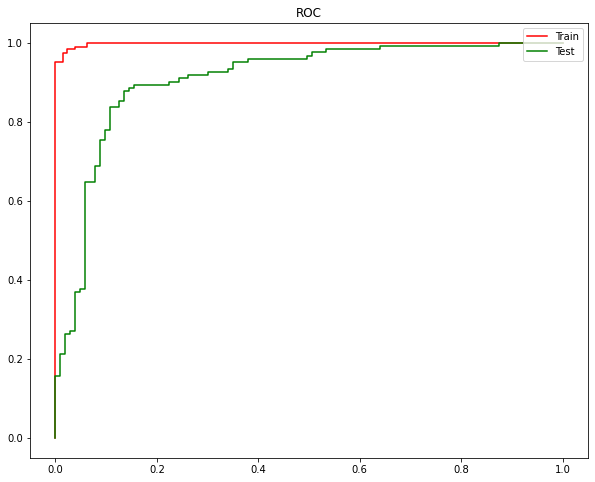

In [116]:
#Plotting ROC_AUC curve and Precision Recall_curve
y_pred_train=pipeline_ensemble.predict_proba(X_train)
y_pred_test=pipeline_ensemble.predict_proba(X_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_train[:,1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train[:,1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(recall_train,precision_train,'-r')
plt.plot(recall_test,precision_test,'-g')
plt.title('Precision_vs_Recall')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'Ensemble_Precision_vs_Recall_Features_{Features}_Training_{Training}.jpg',dpi=600)
plt.figure(figsize=(10,8))
plt.plot(fpr_train,tpr_train,'-r')
plt.plot(fpr_test,tpr_test,'-g')
plt.title('ROC')
plt.legend(['Train','Test'],loc ="upper right")
plt.savefig(f'Ensemble_ROC_Features_{Features}_Training_{Training}_{feature_selection}.jpg',dpi=600)